# Assignment - Sentiment Analysis of Movie Reviews

![](https://i.imgur.com/6Wfmf2S.png)

> **Problem Statement**: Apply the TF-IDF technique to train ML models for sentiment analysis using data from the "[Sentiment Analysis on Movie Reviews](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews)" Kaggle competition.


Outline:

1. Download and Explore Dataset
2. Implement the TF-IDF Technique
3. Train baseline model & submit to Kaggle
4. Train & finetune different ML models
3. Document & submit your notebook


Dataset: https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews


- PCA
- SVM and other estimators
- Regression model

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.stats import mode
import joblib
import subprocess
from colorama import Fore, Style
import matplotlib.pyplot as plt
plt.style.use('dark_background')
%matplotlib inline

from imblearn.over_sampling import SMOTE
smote = True

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, make_scorer
# from torchmetrics.functional.classification import multiclass_accuracy, multiclass_f1_score, multiclass_auroc, multiclass_roc

In [2]:
# train_fname = Path("/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip")
# test_fname = Path("/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip")
train_fname = Path("/home/23m1521/datasets/sentiment-analysis-on-movie-reviews/train.tsv.zip")
test_fname = Path("/home/23m1521/datasets/sentiment-analysis-on-movie-reviews/test.tsv.zip")
sub_fname = Path("/home/23m1521/datasets/sentiment-analysis-on-movie-reviews/sampleSubmission.csv")

In [3]:
sample_sub = pd.read_csv(sub_fname)

In [4]:
test_df = pd.read_csv(test_fname, sep="\t")
test_df

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine
...,...,...,...
66287,222348,11855,"A long-winded , predictable scenario ."
66288,222349,11855,"A long-winded , predictable scenario"
66289,222350,11855,"A long-winded ,"
66290,222351,11855,A long-winded


In [5]:
train_df_full = pd.read_csv(train_fname, sep="\t")
train_df_full

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2


In [6]:
train_df_full.Phrase.values[0]

'A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .'

In [7]:
train_df_full.Phrase.values[1]

'A series of escapades demonstrating the adage that what is good for the goose'

In [8]:
num_classes = len(np.unique(train_df_full.Sentiment))
num_classes

5

In [9]:
class_map = {0 :"negative",
             1 :"somewhat negative",
             2 :"neutral",
             3 :"somewhat positive",
             4 :"positive"}

In [10]:
print(train_df_full.Sentiment.value_counts().sort_index())

Sentiment
0     7072
1    27273
2    79582
3    32927
4     9206
Name: count, dtype: int64


In [11]:
print(train_df_full.Sentiment.value_counts(normalize=True).sort_index())

Sentiment
0    0.045316
1    0.174760
2    0.509945
3    0.210989
4    0.058990
Name: proportion, dtype: float64


<Axes: xlabel='Sentiment'>

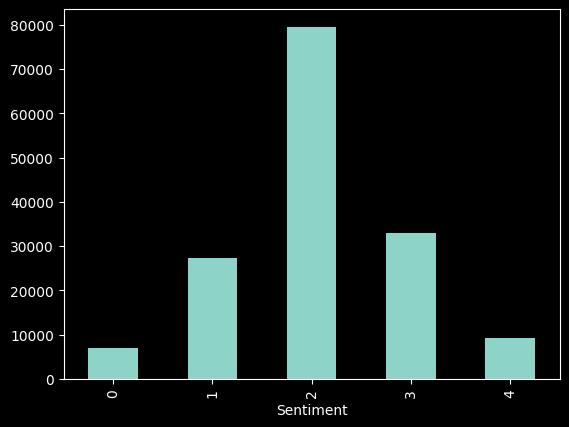

In [12]:
train_df_full.Sentiment.value_counts().sort_index().plot(kind='bar')

## Implement TF-IDF Technique

![](https://i.imgur.com/5VbUPup.png)

Outline:

1. Learn the vocabulary using `TfidfVectorizer`
3. Transform training and test data

#### Learn Vocabulary using `TfidfVectorizer `

* Create custom tokenizer with stemming
* Create a list of stop words
* Configure and create `TfidfVectorizer `
* Learn vocubulary from training set
* View sample entries from vocabulary

In [13]:
def NLP1(text):
    from nltk.tokenize import word_tokenize
    from nltk.corpus import stopwords
    from nltk.stem.snowball import SnowballStemmer
    
    text_tok = word_tokenize(text)
    
    eng_stopwords = stopwords.words('english')
    text_stp = [word for word in text_tok if (word.lower() not in eng_stopwords) and word.isalpha()]
    
    stemmer = SnowballStemmer(language='english')
    text_stm = [stemmer.stem(word) for word in text_stp]
    return text_stm

NLP1(train_df_full.Phrase.values[0])

['seri',
 'escapad',
 'demonstr',
 'adag',
 'good',
 'goos',
 'also',
 'good',
 'gander',
 'occasion',
 'amus',
 'none',
 'amount',
 'much',
 'stori']

In [14]:
eng_stopwords = stopwords.words('english')
", ".join(eng_stopwords)

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [15]:
selected_stopwords = eng_stopwords[:131]
", ".join(selected_stopwords)

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just"

### Vectorization using `CountVectorizer()`

In [16]:
# %%time

# max_features = 2000 # or None
# C_vectorizer = CountVectorizer(lowercase=True, 
#                                tokenizer=NLP1,
#                                stop_words=selected_stopwords,
#                                ngram_range=(1,2),
#                                max_features=max_features).fit(train_df_full.Phrase)

### Vectorization using `TfidfVectorizer()`

In [17]:
max_features = 2000 # or None

In [18]:
# %%time
# T_vectorizer = TfidfVectorizer(lowercase=True, 
#                                tokenizer=NLP1,
#                                stop_words=selected_stopwords,
#                                ngram_range=(1,2),
#                                max_features=max_features).fit(train_df_full.Phrase)
# len(T_vectorizer.vocabulary_)

## Train Baseline Model & Submit to Kaggle

1. Split training and validation sets
2. Train logistic regression model
3. Study predictions on sample phrases
4. Make predictions and submit to Kaggle




In [19]:
train_df_full.shape

(156060, 4)

In [20]:
TRAIN_SIZE = 100_000+5

train_df = train_df_full.iloc[:TRAIN_SIZE, :]
val_df = train_df_full.iloc[TRAIN_SIZE:, :]

print(train_df.shape, val_df.shape)

display(train_df)
display(val_df)

(100005, 4) (56055, 4)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
100000,100001,5247,nothing we Westerners have seen before,2
100001,100002,5247,we Westerners have seen before,2
100002,100003,5247,we Westerners,2
100003,100004,5247,Westerners,2


,PhraseId,SentenceId,Phrase,Sentiment
100005,100006,5248,Has enough gun battles and throwaway humor to ...,1
100006,100007,5248,Has enough gun battles and throwaway humor to ...,1
100007,100008,5248,Has enough gun battles and throwaway,2
100008,100009,5248,enough gun battles and throwaway,2
100009,100010,5248,enough gun battles and,1
...,...,...,...,...
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2


<Axes: xlabel='Sentiment'>

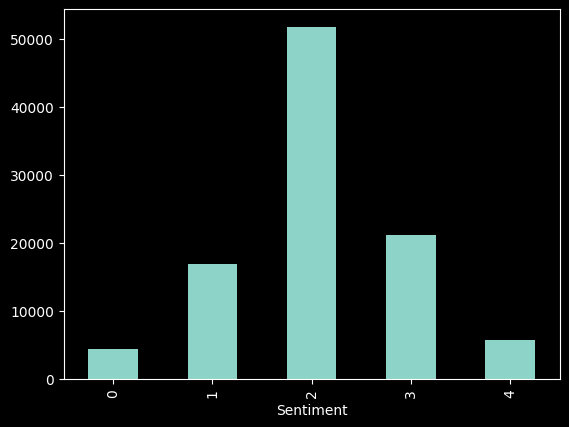

In [21]:
train_df.Sentiment.value_counts().sort_index().plot(kind='bar')

<Axes: xlabel='Sentiment'>

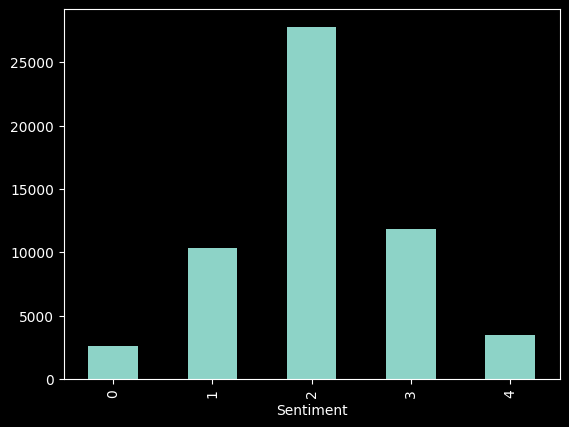

In [22]:
val_df.Sentiment.value_counts().sort_index().plot(kind='bar')

In [23]:
# x_train = C_vectorizer.transform(train_df.Phrase)
# x_val = C_vectorizer.transform(val_df.Phrase)
# y_train = train_df.Sentiment.values
# y_val = val_df.Sentiment.values
# print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

In [24]:
class_wg = dict(train_df_full.Sentiment.value_counts(normalize=True).sort_index())
class_wg

{0: np.float64(0.04531590413943355),
 1: np.float64(0.1747597078046905),
 2: np.float64(0.5099448929898757),
 3: np.float64(0.21098936306548763),
 4: np.float64(0.058990132000512625)}

In [25]:
# x_train = T_vectorizer.transform(train_df.Phrase.values.astype('U'))
# x_val = T_vectorizer.transform(val_df.Phrase.values.astype('U'))
# x_test = T_vectorizer.transform(test_df.Phrase.values.astype('U'))

# y_train = train_df.Sentiment.values
# y_val = val_df.Sentiment.values

# print(x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape)

In [26]:
# joblib.dump(x_train, f'x_train_{max_features}.joblib')
# joblib.dump(x_val, f'x_val_{max_features}.joblib')
# joblib.dump(x_test, f'x_test_{max_features}.joblib')

# joblib.dump(y_train, f'y_train_{max_features}.joblib')
# joblib.dump(y_val, f'y_val_{max_features}.joblib')

In [27]:
x_train_full = joblib.load(f'x_train_{max_features}.joblib')
x_val_full = joblib.load(f'x_val_{max_features}.joblib')
x_test = joblib.load(f'x_test_{max_features}.joblib')

y_train_full = joblib.load(f'y_train_{max_features}.joblib')
y_val_full = joblib.load(f'y_val_{max_features}.joblib')

x_train_full.shape, y_train_full.shape, x_val_full.shape, y_val_full.shape, x_test.shape

((100005, 2000), (100005,), (56055, 2000), (56055,), (66292, 2000))

<Axes: >

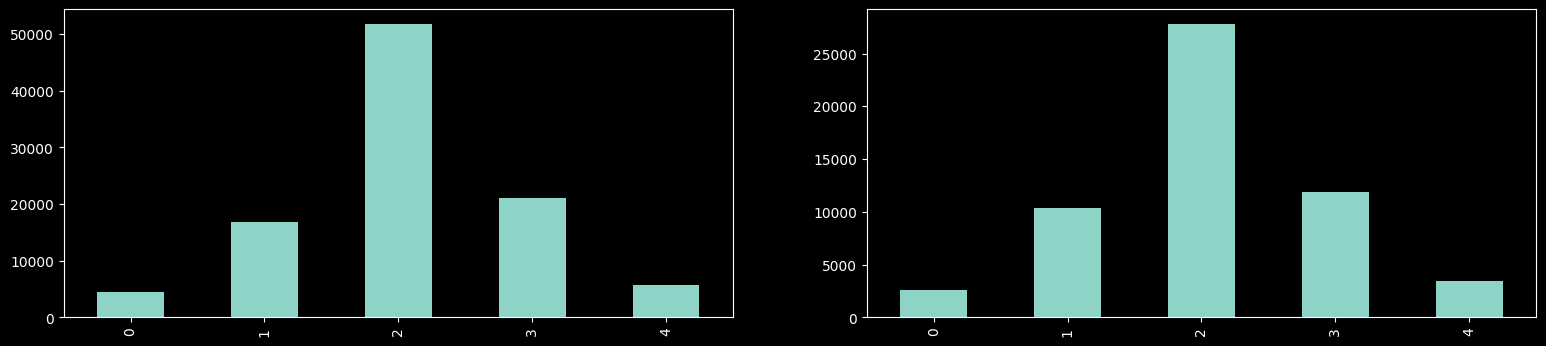

In [28]:
plt.figure(figsize=(19,4))
plt.subplot(1,2,1)
pd.Series(y_train_full).value_counts().sort_index().plot(kind='bar')
plt.subplot(1,2,2)
pd.Series(y_val_full).value_counts().sort_index().plot(kind='bar')

/home/23m1521/.conda/envs/cuda_env/lib/python3.11/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/home/23m1521/.conda/envs/cuda_env/lib/python3.11/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


(258940, 2000) (258940,) (138970, 2000) (138970,) (66292, 2000)


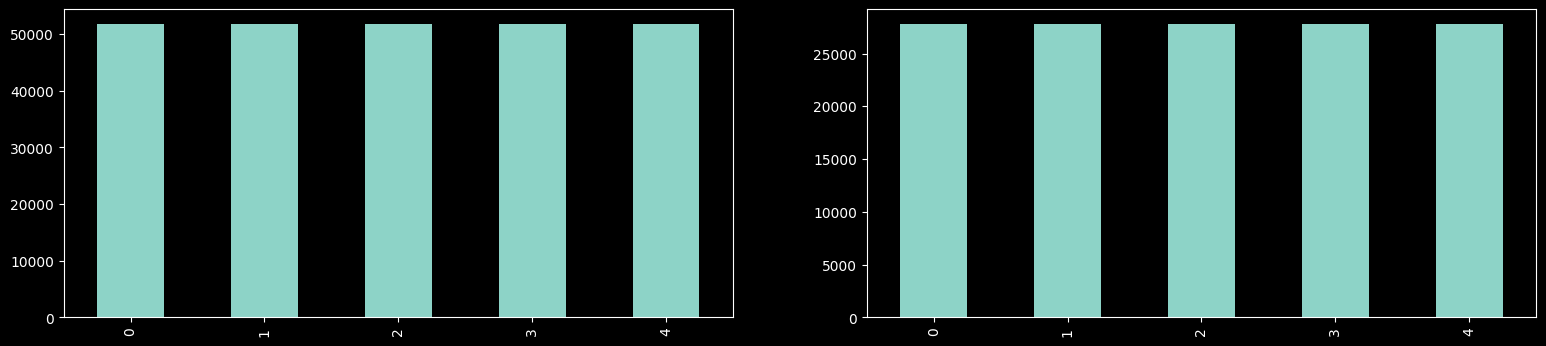

In [29]:
if smote:

    smote = SMOTE(random_state=42, n_jobs=-1)
    x_train_full, y_train_full = smote.fit_resample(x_train_full, y_train_full)

    smote = SMOTE(random_state=42, n_jobs=-1)
    x_val_full, y_val_full = smote.fit_resample(x_val_full, y_val_full)

plt.figure(figsize=(19,4))
plt.subplot(1,2,1)
pd.Series(y_train_full).value_counts().sort_index().plot(kind='bar')
plt.subplot(1,2,2)
pd.Series(y_val_full).value_counts().sort_index().plot(kind='bar')    
print(x_train_full.shape, y_train_full.shape, x_val_full.shape, y_val_full.shape, x_test.shape)

# RandomForestClassifier

In [30]:
BASE_EST = "RF"

In [31]:
MODEL_NAME = f"{BASE_EST}"
SUB_CSV_NAME = f"sub_{MODEL_NAME}.csv"
SUB_CSV_MSG = f"SMOTE={smote} {BASE_EST} TFIDF {int(max_features/1000)}k max features"

cmd1 = f"head {SUB_CSV_NAME}"
cmd2 = f'kaggle competitions submit -c sentiment-analysis-on-movie-reviews -f {SUB_CSV_NAME} -m "{SUB_CSV_MSG}"'
print(SUB_CSV_NAME)
print(cmd1)
print(cmd2)

sub_RF.csv
head sub_RF.csv
kaggle competitions submit -c sentiment-analysis-on-movie-reviews -f sub_RF.csv -m "SMOTE=SMOTE(n_jobs=-1, random_state=42) RF TFIDF 2k max features"


In [32]:
%%time
clf = RandomForestClassifier(n_estimators=1000, criterion='gini', 
                             max_depth=None, random_state=42,
                             verbose=1, n_jobs=-1)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_fold_preds, val_fold_preds, test_fold_preds = [], [], []

for i, (train_index, val_index) in enumerate(cv.split(x_train_full, y_train_full)):
    print(f"Fold: {Fore.YELLOW}{i+1}{Style.RESET_ALL}", end=" | ")
    x_train, y_train = x_train_full[train_index], y_train_full[train_index]
    
    clf.fit(x_train, y_train)

    train_pred = clf.predict(x_train)
    val_pred = clf.predict(x_val_full)
    
    train_fold_preds.append(clf.predict(x_train_full))
    val_fold_preds.append(clf.predict(x_val_full))
    test_fold_preds.append(clf.predict(x_test))

    train_acc = 100*accuracy_score(y_train, train_pred)
    val_acc = 100*accuracy_score(y_val_full, val_pred)

    train_bal_acc = 100*balanced_accuracy_score(y_train, train_pred)
    val_bal_acc = 100*balanced_accuracy_score(y_val_full, val_pred)
    
    train_f1_mic = 100*f1_score(y_train, train_pred, average='micro')
    val_f1_mic = 100*f1_score(y_val_full, val_pred, average='micro')

    train_f1_wg = 100*f1_score(y_train, train_pred, average='weighted')
    val_f1_wg = 100*f1_score(y_val_full, val_pred, average='weighted')

    train_f1_mac = 100*f1_score(y_train, train_pred, average='macro')
    val_f1_mac = 100*f1_score(y_val_full, val_pred, average='macro')
    
    print(f"Acc: ({Fore.YELLOW}{train_acc:.2f}, {val_acc:.2f}{Style.RESET_ALL}) | "
    f"Bal Acc: ({Fore.YELLOW}{train_bal_acc:.2f}, {val_bal_acc:.2f}{Style.RESET_ALL}) | "        
    f"F1 micro: ({Fore.YELLOW}{train_f1_mic:.2f}, {val_f1_mic:.2f}{Style.RESET_ALL})% | "
    f"F1 weighted: ({Fore.YELLOW}{train_f1_wg:.2f}, {val_f1_wg:.2f}{Style.RESET_ALL})% | "
    f"F1 macro: ({Fore.YELLOW}{train_f1_mac:.2f}, {val_f1_mac:.2f}{Style.RESET_ALL})% |")

train_fold_preds = np.array(train_fold_preds)
val_fold_preds = np.array(val_fold_preds)
test_fold_preds = np.array(test_fold_preds)

Fold: 1 | 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.6min finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.7s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    1.8s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    3.5s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    5.0s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    1.3s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    2.4s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | ela

Acc: (85.43, 43.83) | Bal Acc: (85.43, 43.83) | F1 micro: (85.43, 43.83)% | F1 weighted: (85.73, 43.50)% | F1 macro: (85.73, 43.50)% |
Fold: 2 | 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:   57.9s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.8min finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.6s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    1.8s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    3.5s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    5.0s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    1.3s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    2.5s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | ela

Acc: (85.42, 43.60) | Bal Acc: (85.42, 43.60) | F1 micro: (85.42, 43.60)% | F1 weighted: (85.71, 43.30)% | F1 macro: (85.71, 43.30)% |
Fold: 3 | 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:   57.6s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.7min finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.7s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    1.9s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    3.6s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    5.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    1.3s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    2.5s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | ela

Acc: (85.43, 43.72) | Bal Acc: (85.43, 43.72) | F1 micro: (85.43, 43.72)% | F1 weighted: (85.73, 43.38)% | F1 macro: (85.73, 43.38)% |
Fold: 4 | 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.7min finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.7s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    1.9s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    3.5s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    5.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    1.3s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    2.5s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | ela

Acc: (85.42, 43.81) | Bal Acc: (85.42, 43.81) | F1 micro: (85.42, 43.81)% | F1 weighted: (85.71, 43.47)% | F1 macro: (85.71, 43.47)% |
Fold: 5 | 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:   58.4s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.7min finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.7s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    1.8s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    3.6s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    5.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    1.3s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    2.5s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | ela

Acc: (85.44, 43.95) | Bal Acc: (85.44, 43.95) | F1 micro: (85.44, 43.95)% | F1 weighted: (85.72, 43.66)% | F1 macro: (85.72, 43.66)% |
CPU times: user 15h 41min 28s, sys: 27.7 s, total: 15h 41min 56s
Wall time: 15min 12s


[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    2.5s finished


In [33]:
train_pred, _ = mode(train_fold_preds, axis=0)
val_pred, _ = mode(val_fold_preds, axis=0)
test_pred, _ = mode(test_fold_preds, axis=0)

train_acc = 100*accuracy_score(y_train_full, train_pred)
val_acc = 100*accuracy_score(y_val_full, val_pred)

train_bal_acc = 100*balanced_accuracy_score(y_train_full, train_pred)
val_bal_acc = 100*balanced_accuracy_score(y_val_full, val_pred)

train_f1_mic = 100*f1_score(y_train_full, train_pred, average='micro')
val_f1_mic = 100*f1_score(y_val_full, val_pred, average='micro')

train_f1_wg = 100*f1_score(y_train_full, train_pred, average='weighted')
val_f1_wg = 100*f1_score(y_val_full, val_pred, average='weighted')

train_f1_mac = 100*f1_score(y_train_full, train_pred, average='macro')
val_f1_mac = 100*f1_score(y_val_full, val_pred, average='macro')

print(f"Acc: ({Fore.YELLOW}{train_acc:.2f}, {val_acc:.2f}{Style.RESET_ALL}) | "
f"Bal Acc: ({Fore.YELLOW}{train_bal_acc:.2f}, {val_bal_acc:.2f}{Style.RESET_ALL}) | "        
f"F1 micro: ({Fore.YELLOW}{train_f1_mic:.2f}, {val_f1_mic:.2f}{Style.RESET_ALL})% | "
f"F1 weighted: ({Fore.YELLOW}{train_f1_wg:.2f}, {val_f1_wg:.2f}{Style.RESET_ALL})% | "
f"F1 macro: ({Fore.YELLOW}{train_f1_mac:.2f}, {val_f1_mac:.2f}{Style.RESET_ALL})% |")

Acc: (84.96, 43.99) | Bal Acc: (84.96, 43.99) | F1 micro: (84.96, 43.99)% | F1 weighted: (85.26, 43.66)% | F1 macro: (85.26, 43.66)% |


In [34]:
sample_sub.Sentiment = test_pred
sample_sub.to_csv(SUB_CSV_NAME, index=False)
subprocess.run(cmd1, shell=True)

PhraseId,Sentiment
156061,4
156062,4
156063,2
156064,4
156065,4
156066,4
156067,4
156068,2
156069,4


CompletedProcess(args='head sub_RF.csv', returncode=0)

In [35]:
subprocess.run(cmd2, shell=True)

100%|██████████| 583k/583k [00:07<00:00, 82.3kB/s] 


Successfully submitted to Sentiment Analysis on Movie Reviews

CompletedProcess(args='kaggle competitions submit -c sentiment-analysis-on-movie-reviews -f sub_RF.csv -m "SMOTE=SMOTE(n_jobs=-1, random_state=42) RF TFIDF 2k max features"', returncode=0)

# Balanced Class Weights

In [36]:
MODEL_NAME = f"BCW_{BASE_EST}"
SUB_CSV_NAME = f"sub_{MODEL_NAME}.csv"
SUB_CSV_MSG = f"SMOT={smote} {BASE_EST} TFIDF {int(max_features/1000)}k max features"

cmd1 = f"head {SUB_CSV_NAME}"
cmd2 = f'kaggle competitions submit -c sentiment-analysis-on-movie-reviews -f {SUB_CSV_NAME} -m "{SUB_CSV_MSG}"'
print(SUB_CSV_NAME)
print(cmd1)
print(cmd2)

sub_BCW_RF.csv
head sub_BCW_RF.csv
kaggle competitions submit -c sentiment-analysis-on-movie-reviews -f sub_BCW_RF.csv -m "SMOT=SMOTE(n_jobs=-1, random_state=42) RF TFIDF 2k max features"


In [37]:
%%time
clf = RandomForestClassifier(n_estimators=1000, criterion='gini', 
                             max_depth=None, random_state=42,
                             verbose=1, n_jobs=-1)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_fold_preds, val_fold_preds, test_fold_preds = [], [], []

for i, (train_index, val_index) in enumerate(cv.split(x_train_full, y_train_full)):
    print(f"Fold: {Fore.YELLOW}{i+1}{Style.RESET_ALL}", end=" | ")
    x_train, y_train = x_train_full[train_index], y_train_full[train_index]
    
    clf.fit(x_train, y_train)

    train_pred = clf.predict(x_train)
    val_pred = clf.predict(x_val_full)
    
    train_fold_preds.append(clf.predict(x_train_full))
    val_fold_preds.append(clf.predict(x_val_full))
    test_fold_preds.append(clf.predict(x_test))

    train_acc = 100*accuracy_score(y_train, train_pred)
    val_acc = 100*accuracy_score(y_val_full, val_pred)

    train_bal_acc = 100*balanced_accuracy_score(y_train, train_pred)
    val_bal_acc = 100*balanced_accuracy_score(y_val_full, val_pred)
    
    train_f1_mic = 100*f1_score(y_train, train_pred, average='micro')
    val_f1_mic = 100*f1_score(y_val_full, val_pred, average='micro')

    train_f1_wg = 100*f1_score(y_train, train_pred, average='weighted')
    val_f1_wg = 100*f1_score(y_val_full, val_pred, average='weighted')

    train_f1_mac = 100*f1_score(y_train, train_pred, average='macro')
    val_f1_mac = 100*f1_score(y_val_full, val_pred, average='macro')
    
    print(f"Acc: ({Fore.YELLOW}{train_acc:.2f}, {val_acc:.2f}{Style.RESET_ALL}) | "
    f"Bal Acc: ({Fore.YELLOW}{train_bal_acc:.2f}, {val_bal_acc:.2f}{Style.RESET_ALL}) | "        
    f"F1 micro: ({Fore.YELLOW}{train_f1_mic:.2f}, {val_f1_mic:.2f}{Style.RESET_ALL})% | "
    f"F1 weighted: ({Fore.YELLOW}{train_f1_wg:.2f}, {val_f1_wg:.2f}{Style.RESET_ALL})% | "
    f"F1 macro: ({Fore.YELLOW}{train_f1_mac:.2f}, {val_f1_mac:.2f}{Style.RESET_ALL})% |")

train_fold_preds = np.array(train_fold_preds)
val_fold_preds = np.array(val_fold_preds)
test_fold_preds = np.array(test_fold_preds)

Fold: 1 | 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:   56.1s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.7min finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.7s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    1.9s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    3.6s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    5.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    1.3s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    2.5s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | ela

Acc: (85.43, 43.83) | Bal Acc: (85.43, 43.83) | F1 micro: (85.43, 43.83)% | F1 weighted: (85.73, 43.50)% | F1 macro: (85.73, 43.50)% |
Fold: 2 | 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:   57.6s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.7min finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.7s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    1.8s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    3.5s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    5.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    1.3s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    2.5s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | ela

Acc: (85.42, 43.60) | Bal Acc: (85.42, 43.60) | F1 micro: (85.42, 43.60)% | F1 weighted: (85.71, 43.30)% | F1 macro: (85.71, 43.30)% |
Fold: 3 | 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:   58.2s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.7min finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.7s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    1.8s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    3.5s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    5.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    1.3s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    2.5s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | ela

Acc: (85.43, 43.72) | Bal Acc: (85.43, 43.72) | F1 micro: (85.43, 43.72)% | F1 weighted: (85.73, 43.38)% | F1 macro: (85.73, 43.38)% |
Fold: 4 | 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:   57.7s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.7min finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.7s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    1.8s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    3.6s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    5.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    1.3s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    2.5s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | ela

Acc: (85.42, 43.81) | Bal Acc: (85.42, 43.81) | F1 micro: (85.42, 43.81)% | F1 weighted: (85.71, 43.47)% | F1 macro: (85.71, 43.47)% |
Fold: 5 | 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:   58.0s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.7min finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.7s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    1.9s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    3.6s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    5.2s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    1.3s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    2.5s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | ela

Acc: (85.44, 43.95) | Bal Acc: (85.44, 43.95) | F1 micro: (85.44, 43.95)% | F1 weighted: (85.72, 43.66)% | F1 macro: (85.72, 43.66)% |
CPU times: user 15h 48min 45s, sys: 26.3 s, total: 15h 49min 11s
Wall time: 15min 17s


[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    2.5s finished


In [38]:
train_pred, _ = mode(train_fold_preds, axis=0)
val_pred, _ = mode(val_fold_preds, axis=0)
test_pred, _ = mode(test_fold_preds, axis=0)

train_acc = 100*accuracy_score(y_train_full, train_pred)
val_acc = 100*accuracy_score(y_val_full, val_pred)

train_bal_acc = 100*balanced_accuracy_score(y_train_full, train_pred)
val_bal_acc = 100*balanced_accuracy_score(y_val_full, val_pred)

train_f1_mic = 100*f1_score(y_train_full, train_pred, average='micro')
val_f1_mic = 100*f1_score(y_val_full, val_pred, average='micro')

train_f1_wg = 100*f1_score(y_train_full, train_pred, average='weighted')
val_f1_wg = 100*f1_score(y_val_full, val_pred, average='weighted')

train_f1_mac = 100*f1_score(y_train_full, train_pred, average='macro')
val_f1_mac = 100*f1_score(y_val_full, val_pred, average='macro')

print(f"Acc: ({Fore.YELLOW}{train_acc:.2f}, {val_acc:.2f}{Style.RESET_ALL}) | "
f"Bal Acc: ({Fore.YELLOW}{train_bal_acc:.2f}, {val_bal_acc:.2f}{Style.RESET_ALL}) | "        
f"F1 micro: ({Fore.YELLOW}{train_f1_mic:.2f}, {val_f1_mic:.2f}{Style.RESET_ALL})% | "
f"F1 weighted: ({Fore.YELLOW}{train_f1_wg:.2f}, {val_f1_wg:.2f}{Style.RESET_ALL})% | "
f"F1 macro: ({Fore.YELLOW}{train_f1_mac:.2f}, {val_f1_mac:.2f}{Style.RESET_ALL})% |")

Acc: (84.96, 43.99) | Bal Acc: (84.96, 43.99) | F1 micro: (84.96, 43.99)% | F1 weighted: (85.26, 43.66)% | F1 macro: (85.26, 43.66)% |


In [39]:
sample_sub.Sentiment = test_pred
sample_sub.to_csv(SUB_CSV_NAME, index=False)
subprocess.run(cmd1, shell=True)

PhraseId,Sentiment
156061,4
156062,4
156063,2
156064,4
156065,4
156066,4
156067,4
156068,2
156069,4


CompletedProcess(args='head sub_BCW_RF.csv', returncode=0)

In [40]:
subprocess.run(cmd2, shell=True)

100%|██████████| 583k/583k [00:07<00:00, 83.3kB/s] 


Successfully submitted to Sentiment Analysis on Movie Reviews

CompletedProcess(args='kaggle competitions submit -c sentiment-analysis-on-movie-reviews -f sub_BCW_RF.csv -m "SMOT=SMOTE(n_jobs=-1, random_state=42) RF TFIDF 2k max features"', returncode=0)

# OneVsRestClassifier

In [41]:
from sklearn.multiclass import OneVsRestClassifier

In [42]:
MODEL_NAME = f"OvR_{BASE_EST}"
SUB_CSV_NAME = f"sub_{MODEL_NAME}.csv"
SUB_CSV_MSG = f"SMOTE={smote} One vs rest {BASE_EST} TFIDF {int(max_features/1000)}k max features"

cmd1 = f"head {SUB_CSV_NAME}"
cmd2 = f'kaggle competitions submit -c sentiment-analysis-on-movie-reviews -f {SUB_CSV_NAME} -m "{SUB_CSV_MSG}"'
print(SUB_CSV_NAME)
print(cmd1)
print(cmd2)

sub_OvR_RF.csv
head sub_OvR_RF.csv
kaggle competitions submit -c sentiment-analysis-on-movie-reviews -f sub_OvR_RF.csv -m "SMOTE=SMOTE(n_jobs=-1, random_state=42) One vs rest RF TFIDF 2k max features"


In [59]:
%%time
base_est = RandomForestClassifier(n_estimators=1000, criterion='gini', 
                             max_depth=None, random_state=42,
                             verbose=1, n_jobs=-1)

clf = OneVsRestClassifier(base_est, n_jobs=-1)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_fold_preds, val_fold_preds, test_fold_preds = [], [], []

for i, (train_index, val_index) in enumerate(cv.split(x_train_full, y_train_full)):
    print(f"Fold: {Fore.YELLOW}{i+1}{Style.RESET_ALL}", end=" | ")
    x_train, y_train = x_train_full[train_index], y_train_full[train_index]
    
    clf.fit(x_train, y_train)

    train_pred = clf.predict(x_train)
    val_pred = clf.predict(x_val_full)
    
    train_fold_preds.append(clf.predict(x_train_full))
    val_fold_preds.append(clf.predict(x_val_full))
    test_fold_preds.append(clf.predict(x_test))

    train_acc = 100*accuracy_score(y_train, train_pred)
    val_acc = 100*accuracy_score(y_val_full, val_pred)

    train_bal_acc = 100*balanced_accuracy_score(y_train, train_pred)
    val_bal_acc = 100*balanced_accuracy_score(y_val_full, val_pred)
    
    train_f1_mic = 100*f1_score(y_train, train_pred, average='micro')
    val_f1_mic = 100*f1_score(y_val_full, val_pred, average='micro')

    train_f1_wg = 100*f1_score(y_train, train_pred, average='weighted')
    val_f1_wg = 100*f1_score(y_val_full, val_pred, average='weighted')

    train_f1_mac = 100*f1_score(y_train, train_pred, average='macro')
    val_f1_mac = 100*f1_score(y_val_full, val_pred, average='macro')
    
    print(f"Acc: ({Fore.YELLOW}{train_acc:.2f}, {val_acc:.2f}{Style.RESET_ALL}) | "
    f"Bal Acc: ({Fore.YELLOW}{train_bal_acc:.2f}, {val_bal_acc:.2f}{Style.RESET_ALL}) | "        
    f"F1 micro: ({Fore.YELLOW}{train_f1_mic:.2f}, {val_f1_mic:.2f}{Style.RESET_ALL})% | "
    f"F1 weighted: ({Fore.YELLOW}{train_f1_wg:.2f}, {val_f1_wg:.2f}{Style.RESET_ALL})% | "
    f"F1 macro: ({Fore.YELLOW}{train_f1_mac:.2f}, {val_f1_mac:.2f}{Style.RESET_ALL})% |")

train_fold_preds = np.array(train_fold_preds)
val_fold_preds = np.array(val_fold_preds)
test_fold_preds = np.array(test_fold_preds)

Fold: 1 | 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 322 

Acc: (85.43, 46.11) | Bal Acc: (85.43, 46.11) | F1 micro: (85.43, 46.11)% | F1 weighted: (85.73, 45.70)% | F1 macro: (85.73, 45.70)% |
Fold: 2 | 

[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]

Acc: (85.42, 45.77) | Bal Acc: (85.42, 45.77) | F1 micro: (85.42, 45.77)% | F1 weighted: (85.71, 45.36)% | F1 macro: (85.71, 45.36)% |
Fold: 3 | 

[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.6min finished
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:  2.7min
[Parallel(

Acc: (85.43, 45.73) | Bal Acc: (85.43, 45.73) | F1 micro: (85.43, 45.73)% | F1 weighted: (85.73, 45.30)% | F1 macro: (85.73, 45.30)% |
Fold: 4 | 

[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:  2.6min


In [ ]:
train_pred, _ = mode(train_fold_preds, axis=0)
val_pred, _ = mode(val_fold_preds, axis=0)
test_pred, _ = mode(test_fold_preds, axis=0)

train_acc = 100*accuracy_score(y_train_full, train_pred)
val_acc = 100*accuracy_score(y_val_full, val_pred)

train_bal_acc = 100*balanced_accuracy_score(y_train_full, train_pred)
val_bal_acc = 100*balanced_accuracy_score(y_val_full, val_pred)

train_f1_mic = 100*f1_score(y_train_full, train_pred, average='micro')
val_f1_mic = 100*f1_score(y_val_full, val_pred, average='micro')

train_f1_wg = 100*f1_score(y_train_full, train_pred, average='weighted')
val_f1_wg = 100*f1_score(y_val_full, val_pred, average='weighted')

train_f1_mac = 100*f1_score(y_train_full, train_pred, average='macro')
val_f1_mac = 100*f1_score(y_val_full, val_pred, average='macro')

print(f"Acc: ({Fore.YELLOW}{train_acc:.2f}, {val_acc:.2f}{Style.RESET_ALL}) | "
f"Bal Acc: ({Fore.YELLOW}{train_bal_acc:.2f}, {val_bal_acc:.2f}{Style.RESET_ALL}) | "        
f"F1 micro: ({Fore.YELLOW}{train_f1_mic:.2f}, {val_f1_mic:.2f}{Style.RESET_ALL})% | "
f"F1 weighted: ({Fore.YELLOW}{train_f1_wg:.2f}, {val_f1_wg:.2f}{Style.RESET_ALL})% | "
f"F1 macro: ({Fore.YELLOW}{train_f1_mac:.2f}, {val_f1_mac:.2f}{Style.RESET_ALL})% |")

Acc: (84.96, 43.99) | Bal Acc: (84.96, 43.99) | F1 micro: (84.96, 43.99)% | F1 weighted: (85.26, 43.66)% | F1 macro: (85.26, 43.66)% |


In [ ]:
sample_sub.Sentiment = test_pred
sample_sub.to_csv(SUB_CSV_NAME, index=False)
subprocess.run(cmd1, shell=True)

PhraseId,Sentiment
156061,4
156062,4
156063,2
156064,4
156065,4
156066,4
156067,4
156068,2
156069,4


CompletedProcess(args='head sub_OvR_RF.csv', returncode=0)

In [ ]:
subprocess.run(cmd2, shell=True)

100%|██████████| 583k/583k [00:02<00:00, 249kB/s]


Successfully submitted to Sentiment Analysis on Movie Reviews

CompletedProcess(args='kaggle competitions submit -c sentiment-analysis-on-movie-reviews -f sub_OvR_RF.csv -m "SMOTE=SMOTE(n_jobs=-1, random_state=42) One vs rest RF TFIDF 2k max features"', returncode=0)

# OneVsOneClassifier

In [ ]:
from sklearn.multiclass import OneVsOneClassifier

In [ ]:
MODEL_NAME = f"1v1_{BASE_EST}"
SUB_CSV_NAME = f"sub_{MODEL_NAME}.csv"
SUB_CSV_MSG = f"SMOTE={smote} One vs One {BASE_EST} TFIDF {int(max_features/1000)}k max features"

cmd1 = f"head {SUB_CSV_NAME}"
cmd2 = f'kaggle competitions submit -c sentiment-analysis-on-movie-reviews -f {SUB_CSV_NAME} -m "{SUB_CSV_MSG}"'
print(SUB_CSV_NAME)
print(cmd1)
print(cmd2)

sub_1v1_RF.csv
head sub_1v1_RF.csv
kaggle competitions submit -c sentiment-analysis-on-movie-reviews -f sub_1v1_RF.csv -m "SMOTE=SMOTE(n_jobs=-1, random_state=42) One vs One RF TFIDF 2k max features"


In [ ]:
%%time
base_est = RandomForestClassifier(n_estimators=1000, criterion='gini', 
                             max_depth=None, random_state=42,
                             verbose=1, n_jobs=-1)

clf = OneVsOneClassifier(base_est, n_jobs=-1)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_fold_preds, val_fold_preds, test_fold_preds = [], [], []

for i, (train_index, val_index) in enumerate(cv.split(x_train_full, y_train_full)):
    print(f"Fold: {Fore.YELLOW}{i+1}{Style.RESET_ALL}", end=" | ")
    x_train, y_train = x_train_full[train_index], y_train_full[train_index]
    
    clf.fit(x_train, y_train)

    train_pred = clf.predict(x_train)
    val_pred = clf.predict(x_val_full)
    
    train_fold_preds.append(clf.predict(x_train_full))
    val_fold_preds.append(clf.predict(x_val_full))
    test_fold_preds.append(clf.predict(x_test))

    train_acc = 100*accuracy_score(y_train, train_pred)
    val_acc = 100*accuracy_score(y_val_full, val_pred)

    train_bal_acc = 100*balanced_accuracy_score(y_train, train_pred)
    val_bal_acc = 100*balanced_accuracy_score(y_val_full, val_pred)
    
    train_f1_mic = 100*f1_score(y_train, train_pred, average='micro')
    val_f1_mic = 100*f1_score(y_val_full, val_pred, average='micro')

    train_f1_wg = 100*f1_score(y_train, train_pred, average='weighted')
    val_f1_wg = 100*f1_score(y_val_full, val_pred, average='weighted')

    train_f1_mac = 100*f1_score(y_train, train_pred, average='macro')
    val_f1_mac = 100*f1_score(y_val_full, val_pred, average='macro')
    
    print(f"Acc: ({Fore.YELLOW}{train_acc:.2f}, {val_acc:.2f}{Style.RESET_ALL}) | "
    f"Bal Acc: ({Fore.YELLOW}{train_bal_acc:.2f}, {val_bal_acc:.2f}{Style.RESET_ALL}) | "        
    f"F1 micro: ({Fore.YELLOW}{train_f1_mic:.2f}, {val_f1_mic:.2f}{Style.RESET_ALL})% | "
    f"F1 weighted: ({Fore.YELLOW}{train_f1_wg:.2f}, {val_f1_wg:.2f}{Style.RESET_ALL})% | "
    f"F1 macro: ({Fore.YELLOW}{train_f1_mac:.2f}, {val_f1_mac:.2f}{Style.RESET_ALL})% |")

train_fold_preds = np.array(train_fold_preds)
val_fold_preds = np.array(val_fold_preds)
test_fold_preds = np.array(test_fold_preds)

In [ ]:
train_pred, _ = mode(train_fold_preds, axis=0)
val_pred, _ = mode(val_fold_preds, axis=0)
test_pred, _ = mode(test_fold_preds, axis=0)

train_acc = 100*accuracy_score(y_train_full, train_pred)
val_acc = 100*accuracy_score(y_val_full, val_pred)

train_bal_acc = 100*balanced_accuracy_score(y_train_full, train_pred)
val_bal_acc = 100*balanced_accuracy_score(y_val_full, val_pred)

train_f1_mic = 100*f1_score(y_train_full, train_pred, average='micro')
val_f1_mic = 100*f1_score(y_val_full, val_pred, average='micro')

train_f1_wg = 100*f1_score(y_train_full, train_pred, average='weighted')
val_f1_wg = 100*f1_score(y_val_full, val_pred, average='weighted')

train_f1_mac = 100*f1_score(y_train_full, train_pred, average='macro')
val_f1_mac = 100*f1_score(y_val_full, val_pred, average='macro')

print(f"Acc: ({Fore.YELLOW}{train_acc:.2f}, {val_acc:.2f}{Style.RESET_ALL}) | "
f"Bal Acc: ({Fore.YELLOW}{train_bal_acc:.2f}, {val_bal_acc:.2f}{Style.RESET_ALL}) | "        
f"F1 micro: ({Fore.YELLOW}{train_f1_mic:.2f}, {val_f1_mic:.2f}{Style.RESET_ALL})% | "
f"F1 weighted: ({Fore.YELLOW}{train_f1_wg:.2f}, {val_f1_wg:.2f}{Style.RESET_ALL})% | "
f"F1 macro: ({Fore.YELLOW}{train_f1_mac:.2f}, {val_f1_mac:.2f}{Style.RESET_ALL})% |")

Acc: (84.96, 43.99) | Bal Acc: (84.96, 43.99) | F1 micro: (84.96, 43.99)% | F1 weighted: (85.26, 43.66)% | F1 macro: (85.26, 43.66)% |


In [ ]:
sample_sub.Sentiment = test_pred
sample_sub.to_csv(SUB_CSV_NAME, index=False)
subprocess.run(cmd1, shell=True)

PhraseId,Sentiment
156061,4
156062,4
156063,2
156064,4
156065,4
156066,4
156067,4
156068,2
156069,4


CompletedProcess(args='head sub_1v1_RF.csv', returncode=0)

In [ ]:
subprocess.run(cmd2, shell=True)

100%|██████████| 583k/583k [00:02<00:00, 233kB/s]


Successfully submitted to Sentiment Analysis on Movie Reviews

CompletedProcess(args='kaggle competitions submit -c sentiment-analysis-on-movie-reviews -f sub_1v1_RF.csv -m "SMOTE=SMOTE(n_jobs=-1, random_state=42) One vs One RF TFIDF 2k max features"', returncode=0)

# OutputCodeClassifier

In [ ]:
from sklearn.multiclass import OutputCodeClassifier

In [ ]:
MODEL_NAME = f"OCC_{BASE_EST}"
SUB_CSV_NAME = f"sub_{MODEL_NAME}.csv"
SUB_CSV_MSG = f"SMOTE={smote} OutputCodeClassifier {BASE_EST} TFIDF {int(max_features/1000)}k max features"

cmd1 = f"head {SUB_CSV_NAME}"
cmd2 = f'kaggle competitions submit -c sentiment-analysis-on-movie-reviews -f {SUB_CSV_NAME} -m "{SUB_CSV_MSG}"'
print(SUB_CSV_NAME)
print(cmd1)
print(cmd2)

sub_OCC_RF.csv
head sub_OCC_RF.csv
kaggle competitions submit -c sentiment-analysis-on-movie-reviews -f sub_OCC_RF.csv -m "SMOTE=SMOTE(n_jobs=-1, random_state=42) OutputCodeClassifier RF TFIDF 2k max features"


In [ ]:
%%time
base_est = RandomForestClassifier(n_estimators=1000, criterion='gini', 
                             max_depth=None, random_state=42,
                             verbose=1, n_jobs=-1)

clf = OutputCodeClassifier(base_est, n_jobs=-1)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_fold_preds, val_fold_preds, test_fold_preds = [], [], []

for i, (train_index, val_index) in enumerate(cv.split(x_train_full, y_train_full)):
    print(f"Fold: {Fore.YELLOW}{i+1}{Style.RESET_ALL}", end=" | ")
    x_train, y_train = x_train_full[train_index], y_train_full[train_index]
    
    clf.fit(x_train, y_train)

    train_pred = clf.predict(x_train)
    val_pred = clf.predict(x_val_full)
    
    train_fold_preds.append(clf.predict(x_train_full))
    val_fold_preds.append(clf.predict(x_val_full))
    test_fold_preds.append(clf.predict(x_test))

    train_acc = 100*accuracy_score(y_train, train_pred)
    val_acc = 100*accuracy_score(y_val_full, val_pred)

    train_bal_acc = 100*balanced_accuracy_score(y_train, train_pred)
    val_bal_acc = 100*balanced_accuracy_score(y_val_full, val_pred)
    
    train_f1_mic = 100*f1_score(y_train, train_pred, average='micro')
    val_f1_mic = 100*f1_score(y_val_full, val_pred, average='micro')

    train_f1_wg = 100*f1_score(y_train, train_pred, average='weighted')
    val_f1_wg = 100*f1_score(y_val_full, val_pred, average='weighted')

    train_f1_mac = 100*f1_score(y_train, train_pred, average='macro')
    val_f1_mac = 100*f1_score(y_val_full, val_pred, average='macro')
    
    print(f"Acc: ({Fore.YELLOW}{train_acc:.2f}, {val_acc:.2f}{Style.RESET_ALL}) | "
    f"Bal Acc: ({Fore.YELLOW}{train_bal_acc:.2f}, {val_bal_acc:.2f}{Style.RESET_ALL}) | "        
    f"F1 micro: ({Fore.YELLOW}{train_f1_mic:.2f}, {val_f1_mic:.2f}{Style.RESET_ALL})% | "
    f"F1 weighted: ({Fore.YELLOW}{train_f1_wg:.2f}, {val_f1_wg:.2f}{Style.RESET_ALL})% | "
    f"F1 macro: ({Fore.YELLOW}{train_f1_mac:.2f}, {val_f1_mac:.2f}{Style.RESET_ALL})% |")

train_fold_preds = np.array(train_fold_preds)
val_fold_preds = np.array(val_fold_preds)
test_fold_preds = np.array(test_fold_preds)

In [ ]:
train_pred, _ = mode(train_fold_preds, axis=0)
val_pred, _ = mode(val_fold_preds, axis=0)
test_pred, _ = mode(test_fold_preds, axis=0)

train_acc = 100*accuracy_score(y_train_full, train_pred)
val_acc = 100*accuracy_score(y_val_full, val_pred)

train_bal_acc = 100*balanced_accuracy_score(y_train_full, train_pred)
val_bal_acc = 100*balanced_accuracy_score(y_val_full, val_pred)

train_f1_mic = 100*f1_score(y_train_full, train_pred, average='micro')
val_f1_mic = 100*f1_score(y_val_full, val_pred, average='micro')

train_f1_wg = 100*f1_score(y_train_full, train_pred, average='weighted')
val_f1_wg = 100*f1_score(y_val_full, val_pred, average='weighted')

train_f1_mac = 100*f1_score(y_train_full, train_pred, average='macro')
val_f1_mac = 100*f1_score(y_val_full, val_pred, average='macro')

print(f"Acc: ({Fore.YELLOW}{train_acc:.2f}, {val_acc:.2f}{Style.RESET_ALL}) | "
f"Bal Acc: ({Fore.YELLOW}{train_bal_acc:.2f}, {val_bal_acc:.2f}{Style.RESET_ALL}) | "        
f"F1 micro: ({Fore.YELLOW}{train_f1_mic:.2f}, {val_f1_mic:.2f}{Style.RESET_ALL})% | "
f"F1 weighted: ({Fore.YELLOW}{train_f1_wg:.2f}, {val_f1_wg:.2f}{Style.RESET_ALL})% | "
f"F1 macro: ({Fore.YELLOW}{train_f1_mac:.2f}, {val_f1_mac:.2f}{Style.RESET_ALL})% |")

Acc: (84.96, 43.99) | Bal Acc: (84.96, 43.99) | F1 micro: (84.96, 43.99)% | F1 weighted: (85.26, 43.66)% | F1 macro: (85.26, 43.66)% |


In [ ]:
sample_sub.Sentiment = test_pred
sample_sub.to_csv(SUB_CSV_NAME, index=False)
subprocess.run(cmd1, shell=True)

PhraseId,Sentiment
156061,4
156062,4
156063,2
156064,4
156065,4
156066,4
156067,4
156068,2
156069,4


CompletedProcess(args='head sub_OCC_RF.csv', returncode=0)

In [ ]:
subprocess.run(cmd2, shell=True)

100%|██████████| 583k/583k [00:02<00:00, 252kB/s]


Successfully submitted to Sentiment Analysis on Movie Reviews

CompletedProcess(args='kaggle competitions submit -c sentiment-analysis-on-movie-reviews -f sub_OCC_RF.csv -m "SMOTE=SMOTE(n_jobs=-1, random_state=42) OutputCodeClassifier RF TFIDF 2k max features"', returncode=0)